<a href="https://colab.research.google.com/github/rygo1232/ryan1/blob/main/DP_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!pip install bayesian-optimization


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from google.colab import drive
tfd = tfp.distributions

In [13]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/OPR_Data.xlsx'
opr_data = pd.read_excel(file_path)
opr_data.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,loss,Internal_fraud,External_fraud,EmployPWS,ClientsPBP,Disaster,ICTFailure,ExecutionDP
0,1980,2955.0,98.9,465.2,76.7,1816.4,40.0,50.3,407.5
1,1981,33259.6,890.9,589.2,291.0,18275.0,9.4,3851.0,9353.1
2,1982,52783.9,950.0,7045.2,3394.7,26504.3,389.7,844.4,13655.6
3,1983,4071.8,161.1,304.4,233.8,2456.2,2.1,27.6,886.6
4,1984,24008.2,158.4,4514.0,240.0,12962.0,30.3,678.4,5425.1


# **new model**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from google.colab import drive
tfd = tfp.distributions

# **Data Preparation**

In [15]:
# Mount Google Drive
drive.mount('/content/drive')

# Load and prepare data
def load_and_prepare_data(file_path):
    # Load data
    opr_data = pd.read_excel(file_path)

    # Handle missing values
    opr_data.fillna(method='ffill', inplace=True)

    # Encode categorical features
    categorical_cols = opr_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        opr_data[col] = le.fit_transform(opr_data[col])
        label_encoders[col] = le

    # Scale numerical features
    numerical_cols = opr_data.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    opr_data[numerical_cols] = scaler.fit_transform(opr_data[numerical_cols])

    # Prepare features and target
    X = opr_data.drop('loss', axis=1, errors='ignore')
    y = opr_data['loss']

    # Shuffle and split
    X, y = shuffle(X, y, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    return X_train, X_test, y_train, y_test, scaler, label_encoders

# Load your data
file_path = '/content/drive/MyDrive/Colab Notebooks/OPR_Data.xlsx'
X_train, X_test, y_train, y_test, scaler, label_encoders = load_and_prepare_data(file_path)

# Print the shapes to verify
print("Shapes after conversion:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shapes after conversion:
X_train shape: (36, 8), y_train shape: (36, 1)
X_test shape: (9, 8), y_test shape: (9, 1)


<ipython-input-15-904e052b2c7a>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  opr_data.fillna(method='ffill', inplace=True)


# **ANN Model**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.7795 - mae: 0.7365 - val_loss: 0.6241 - val_mae: 0.6374
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.6404 - mae: 0.6450 - val_loss: 0.5360 - val_mae: 0.5792
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4667 - mae: 0.5670 - val_loss: 0.4540 - val_mae: 0.5401
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3995 - mae: 0.4984 - val_loss: 0.3850 - val_mae: 0.5047
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3708 - mae: 0.5119 - val_loss: 0.3388 - val_mae: 0.4956
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3854 - mae: 0.5087 - val_loss: 0.2979 - val_mae: 0.4786
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2586 - mae: 0.4275 - val_loss: 0.2508 - val_mae: 0.4542
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2599 - mae: 0.4402 - val_loss: 0.2073 - val_mae: 0.4215
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1694 - mae: 0.3279 -

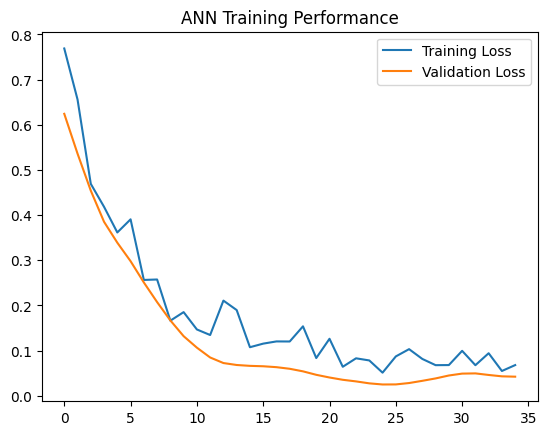


ANN Evaluation:
MSE: 0.0249
MAE: 0.1366
R²: 0.9784


In [16]:
def build_train_ann(X_train, y_train, X_test, y_test):
    # Model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                       validation_data=(X_test, y_test),
                       epochs=100, batch_size=32,
                       callbacks=[early_stopping], verbose=1)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ANN Training Performance')
    plt.legend()
    plt.show()

    print(f"\nANN Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")
    return model, history

# Run the ANN
ann_model, ann_history = build_train_ann(X_train, y_train, X_test, y_test)

# **ANN Model 2**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 2.4125 - mae: 0.7712 - val_loss: 3.0279 - val_mae: 0.9181
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2.3739 - mae: 0.7521 - val_loss: 2.7238 - val_mae: 0.8468
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.0516 - mae: 0.6600 - val_loss: 2.4733 - val_mae: 0.7819
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.0283 - mae: 0.6350 - val_loss: 2.2899 - val_mae: 0.7369
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.8782 - mae: 0.5780 - val_loss: 2.1636 - val_mae: 0.7077
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.8445 - mae: 0.5710 - val_loss: 2.0540 - val_mae: 0.6828
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.7100 - mae: 0.4811 - val_loss: 1.9527 - val_mae: 0.6579
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.6706 - mae: 0.4647 - val_loss: 1.8550 - val_mae: 0.6297
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.5932 - mae: 0.4263 - va

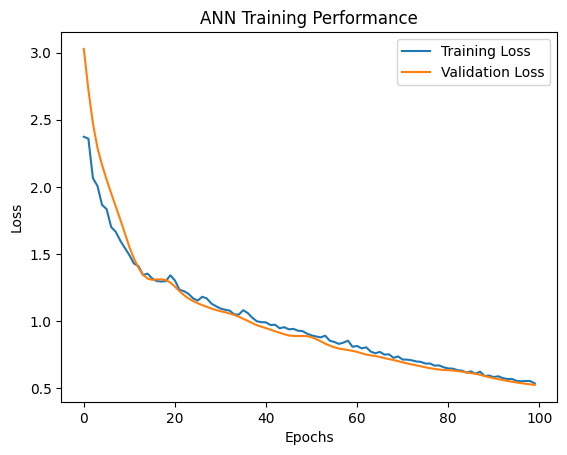


ANN Evaluation:
MSE: 0.0133
MAE: 0.1087
R²: 0.9884


In [17]:

def build_train_ann(X_train, y_train, X_test, y_test):
    # Model architecture with L2 Regularization
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
        Dropout(0.3),  # Dropout layer to reduce overfitting
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Optional L2 Regularization
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Optional L2 Regularization
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=100, batch_size=32,
                        callbacks=[early_stopping], verbose=1)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ANN Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"\nANN Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")
    return model, history

# Run the ANN
ann_model, ann_history = build_train_ann(X_train, y_train, X_test, y_test)

# **LSTM Model**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - loss: 0.8458 - mae: 0.7240 - val_loss: 1.4787 - val_mae: 0.8884
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8760 - mae: 0.7407 - val_loss: 1.4584 - val_mae: 0.8825
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.8709 - mae: 0.7363 - val_loss: 1.4404 - val_mae: 0.8774
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.8666 - mae: 0.7413 - val_loss: 1.4199 - val_mae: 0.8718
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.8679 - mae: 0.7398 - val_loss: 1.4027 - val_mae: 0.8676
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.8510 - mae: 0.7353 - val_loss: 1.3847 - val_mae: 0.8632
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.8001 - mae: 0.7065 - val_loss: 1.3635 - val_mae: 0.8577
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.8055 - mae: 0.7123 - val_loss: 1.3397 - val_mae: 0.8512
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.7275 - mae: 0.681

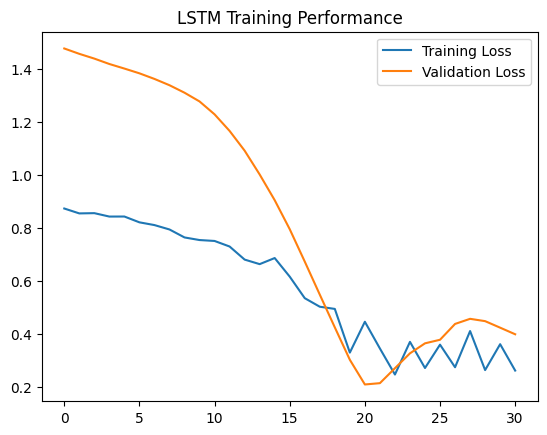


LSTM Evaluation:
MSE: 0.2077
MAE: 0.4320
R²: 0.8202


In [18]:
def build_train_lstm(X_train, y_train, X_test, y_test):
    # Reshape data for LSTM - No need for .values since it's already a NumPy array
    X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model architecture
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        LSTM(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_seq, y_train,
                       validation_data=(X_test_seq, y_test),
                       epochs=100, batch_size=32,
                       callbacks=[early_stopping], verbose=1)

    # Evaluate
    y_pred = model.predict(X_test_seq)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training Performance')
    plt.legend()
    plt.show()

    print(f"\nLSTM Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")
    return model, history
# Run the LSTM
lstm_model, lstm_history = build_train_lstm(X_train, y_train, X_test, y_test)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 693ms/step - loss: 0.8565 - mae: 0.7274 - val_loss: 1.5183 - val_mae: 0.8990
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.8345 - mae: 0.7175 - val_loss: 1.5175 - val_mae: 0.8987
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.8912 - mae: 0.7461 - val_loss: 1.5159 - val_mae: 0.8982
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.8849 - mae: 0.7415 - val_loss: 1.5163 - val_mae: 0.8983
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.8618 - mae: 0.7285 - val_loss: 1.5156 - val_mae: 0.8981
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.8833 - mae: 0.7429 - val_loss: 1.5138 - val_mae: 0.8976
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.8274 - mae: 0.7126 - val_loss: 1.5095 - val_mae: 0.8964
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.8550 - mae: 0.7181 - val_loss: 1.5031 - val_mae: 0.8945
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.8614 - mae: 0.7263 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


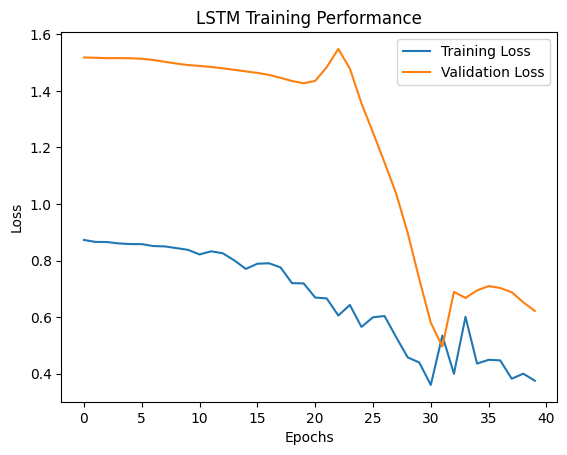


LSTM Evaluation:
MSE: 0.4958
MAE: 0.5873
R²: 0.5709


In [19]:

def build_train_lstm(X_train, y_train, X_test, y_test):
    # Reshape data for LSTM
    X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model architecture
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.4),
        LSTM(32, activation='relu', return_sequences=True),  # Keeping return_sequences for potential additional LSTM layers
        Dropout(0.4),
        LSTM(16, activation='relu'),  # Additional LSTM layer
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile and train with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history = model.fit(X_train_seq, y_train,
                        validation_data=(X_test_seq, y_test),
                        epochs=100, batch_size=32,
                        callbacks=[early_stopping], verbose=1)

    # Evaluate
    y_pred = model.predict(X_test_seq)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training Performance')
    plt.xlabel('Epochs')  # Added x-label for clarity
    plt.ylabel('Loss')     # Added y-label for clarity
    plt.legend()
    plt.show()

    print(f"\nLSTM Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")
    return model, history

# Run the LSTM
lstm_model, lstm_history = build_train_lstm(X_train, y_train, X_test, y_test)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.9545 - mae: 0.7507

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - loss: 0.9320 - mae: 0.7509 - val_loss: 1.5847 - val_mae: 0.9152 - learning_rate: 8.0000e-04
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9879 - mae: 0.8092

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.9183 - mae: 0.7625 - val_loss: 1.5544 - val_mae: 0.9067 - learning_rate: 8.0000e-04
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8390 - mae: 0.7299

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.8544 - mae: 0.7306 - val_loss: 1.5315 - val_mae: 0.9007 - learning_rate: 8.0000e-04
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8944 - mae: 0.7351

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.8635 - mae: 0.7286 - val_loss: 1.5066 - val_mae: 0.8938 - learning_rate: 8.0000e-04
Epoch 5/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9013 - mae: 0.7517

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.8611 - mae: 0.7306 - val_loss: 1.4824 - val_mae: 0.8871 - learning_rate: 8.0000e-04
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.8796 - mae: 0.7456

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.8377 - mae: 0.7234 - val_loss: 1.4546 - val_mae: 0.8792 - learning_rate: 8.0000e-04
Epoch 7/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8715 - mae: 0.7296

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.8342 - mae: 0.7164 - val_loss: 1.4297 - val_mae: 0.8719 - learning_rate: 8.0000e-04
Epoch 8/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.8229 - mae: 0.7224

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.7992 - mae: 0.7080 - val_loss: 1.4036 - val_mae: 0.8640 - learning_rate: 8.0000e-04
Epoch 9/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8525 - mae: 0.7486

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.7999 - mae: 0.7143 - val_loss: 1.3761 - val_mae: 0.8550 - learning_rate: 8.0000e-04
Epoch 10/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.6985 - mae: 0.6728

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.7262 - mae: 0.6807 - val_loss: 1.3409 - val_mae: 0.8438 - learning_rate: 8.0000e-04
Epoch 11/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.6923 - mae: 0.6642

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.7050 - mae: 0.6663 - val_loss: 1.2936 - val_mae: 0.8290 - learning_rate: 8.0000e-04
Epoch 12/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.7323 - mae: 0.6905

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.7104 - mae: 0.6736 - val_loss: 1.2395 - val_mae: 0.8176 - learning_rate: 8.0000e-04
Epoch 13/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.5583 - mae: 0.6087

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.6430 - mae: 0.6445 - val_loss: 1.1832 - val_mae: 0.8116 - learning_rate: 8.0000e-04
Epoch 14/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.6319 - mae: 0.6399

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.6425 - mae: 0.6454 - val_loss: 1.1194 - val_mae: 0.8034 - learning_rate: 8.0000e-04
Epoch 15/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.6636 - mae: 0.6667

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.6220 - mae: 0.6379 - val_loss: 1.0521 - val_mae: 0.7950 - learning_rate: 8.0000e-04
Epoch 16/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.5506 - mae: 0.6078

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.5683 - mae: 0.6144 - val_loss: 0.9899 - val_mae: 0.7897 - learning_rate: 8.0000e-04
Epoch 17/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.5775 - mae: 0.6315

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.5463 - mae: 0.6104 - val_loss: 0.9333 - val_mae: 0.7876 - learning_rate: 8.0000e-04
Epoch 18/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.4590 - mae: 0.5566

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.4888 - mae: 0.5729 - val_loss: 0.8768 - val_mae: 0.7861 - learning_rate: 8.0000e-04
Epoch 19/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.5477 - mae: 0.5955

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.5305 - mae: 0.5912 - val_loss: 0.8218 - val_mae: 0.7844 - learning_rate: 8.0000e-04
Epoch 20/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.3656 - mae: 0.5147

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.4184 - mae: 0.5400 - val_loss: 0.7683 - val_mae: 0.7812 - learning_rate: 8.0000e-04
Epoch 21/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.4602 - mae: 0.5619

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.4483 - mae: 0.5586 - val_loss: 0.7174 - val_mae: 0.7772 - learning_rate: 8.0000e-04
Epoch 22/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.4274 - mae: 0.5671

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.4082 - mae: 0.5543 - val_loss: 0.6792 - val_mae: 0.7757 - learning_rate: 8.0000e-04
Epoch 23/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4901 - mae: 0.6066

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.4673 - mae: 0.5833 - val_loss: 0.6473 - val_mae: 0.7711 - learning_rate: 8.0000e-04
Epoch 24/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4287 - mae: 0.5710

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.4072 - mae: 0.5560 - val_loss: 0.6118 - val_mae: 0.7588 - learning_rate: 8.0000e-04
Epoch 25/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3586 - mae: 0.5271

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.3418 - mae: 0.5122 - val_loss: 0.5815 - val_mae: 0.7464 - learning_rate: 8.0000e-04
Epoch 26/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3832 - mae: 0.5432

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.3791 - mae: 0.5410 - val_loss: 0.5547 - val_mae: 0.7336 - learning_rate: 8.0000e-04
Epoch 27/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3514 - mae: 0.5284

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3465 - mae: 0.5253 - val_loss: 0.5229 - val_mae: 0.7149 - learning_rate: 8.0000e-04
Epoch 28/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3232 - mae: 0.5013

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.3321 - mae: 0.5103 - val_loss: 0.4826 - val_mae: 0.6880 - learning_rate: 8.0000e-04
Epoch 29/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3150 - mae: 0.4830

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3456 - mae: 0.5061 - val_loss: 0.4520 - val_mae: 0.6659 - learning_rate: 8.0000e-04
Epoch 30/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3403 - mae: 0.5340

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3454 - mae: 0.5352 - val_loss: 0.4340 - val_mae: 0.6510 - learning_rate: 8.0000e-04
Epoch 31/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3404 - mae: 0.5147

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.3447 - mae: 0.5198 - val_loss: 0.4198 - val_mae: 0.6385 - learning_rate: 8.0000e-04
Epoch 32/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.3509 - mae: 0.5093

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3342 - mae: 0.4961 - val_loss: 0.4032 - val_mae: 0.6245 - learning_rate: 8.0000e-04
Epoch 33/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3536 - mae: 0.5312

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3417 - mae: 0.5203 - val_loss: 0.3872 - val_mae: 0.6114 - learning_rate: 8.0000e-04
Epoch 34/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3148 - mae: 0.4797

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.3168 - mae: 0.4837 - val_loss: 0.3779 - val_mae: 0.6044 - learning_rate: 8.0000e-04
Epoch 35/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3302 - mae: 0.5001

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3299 - mae: 0.4988 - val_loss: 0.3635 - val_mae: 0.5944 - learning_rate: 8.0000e-04
Epoch 36/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3391 - mae: 0.5223

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.3370 - mae: 0.5221 - val_loss: 0.3450 - val_mae: 0.5809 - learning_rate: 8.0000e-04
Epoch 37/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2851 - mae: 0.4736

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2880 - mae: 0.4779 - val_loss: 0.3308 - val_mae: 0.5705 - learning_rate: 8.0000e-04
Epoch 38/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2507 - mae: 0.4301

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2606 - mae: 0.4424 - val_loss: 0.3232 - val_mae: 0.5648 - learning_rate: 8.0000e-04
Epoch 39/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3300 - mae: 0.4985

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3114 - mae: 0.4811 - val_loss: 0.3207 - val_mae: 0.5627 - learning_rate: 8.0000e-04
Epoch 40/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3049 - mae: 0.4930

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2961 - mae: 0.4826 - val_loss: 0.3170 - val_mae: 0.5594 - learning_rate: 8.0000e-04
Epoch 41/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2745 - mae: 0.4527

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2619 - mae: 0.4400 - val_loss: 0.3131 - val_mae: 0.5556 - learning_rate: 8.0000e-04
Epoch 42/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3166 - mae: 0.4866 - val_loss: 0.3167 - val_mae: 0.5588 - learning_rate: 8.0000e-04
Epoch 43/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2556 - mae: 0.4291 - val_loss: 0.3289 - val_mae: 0.5696 - learning_rate: 8.0000e-04
Epoch 44/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2760 - mae: 0.4535 - val_loss: 0.3347 - val_mae: 0.5744 - learning_rate: 8.0000e-04
Epoch 45/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2623 - mae: 0.4471 - val_loss: 0.3363 - val_mae: 0.5754 - learning_rate: 8.0000e-04
Epoch 46/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2798 - mae: 0.4628 - val_loss: 0.3395 - val_mae: 0.5779 - learning_rate: 8.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


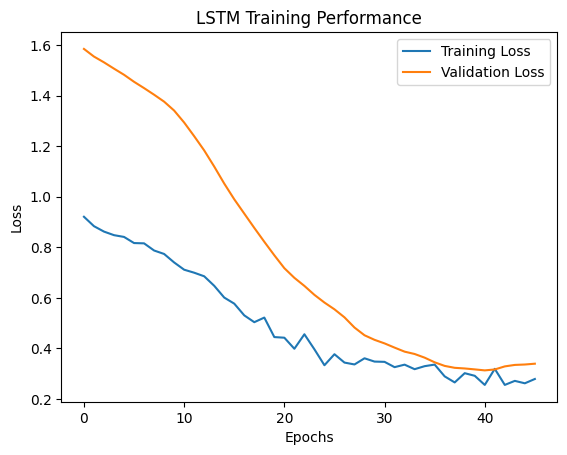


LSTM Evaluation:
MSE: 0.3131
MAE: 0.5556
R²: 0.7291


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_train_lstm(X_train, y_train, X_test, y_test):
    # Reshape data for LSTM
    X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model architecture
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        LSTM(32, return_sequences=False, activation='tanh'),  # Removed activation for last LSTM
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='mse', metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

    # Training process
    history = model.fit(X_train_seq, y_train,
                        validation_data=(X_test_seq, y_test),
                        epochs=100, batch_size=32,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr],
                        verbose=1)

    # Evaluate
    y_pred = model.predict(X_test_seq)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"\nLSTM Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

    return model, history

# Run the LSTM
lstm_model, lstm_history = build_train_lstm(X_train, y_train, X_test, y_test)

# Autoencoder

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 1.1891 - val_loss: 1.5661
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.1865 - val_loss: 1.5560
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.1604 - val_loss: 1.5467
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1765 - val_loss: 1.5381
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.1746 - val_loss: 1.5307
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.1556 - val_loss: 1.5236
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.1574 - val_loss: 1.5159
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.1562 - val_loss: 1.5073
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.1354 - val_loss: 1.4970
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.1457 - val_loss: 1.4854
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.1322 - val_loss: 1.4730
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.1180 - val_l

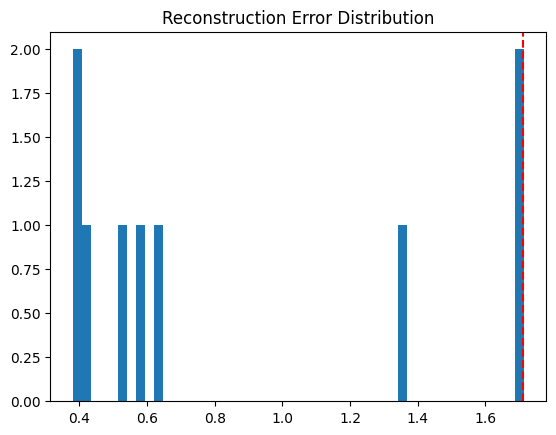


Anomalies detected: 1/9


In [21]:
def build_train_autoencoder(X_train, X_test):
    # Model architecture
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    # Train
    history = model.fit(X_train, X_train,
                       epochs=100, batch_size=32,
                       validation_data=(X_test, X_test),
                       verbose=1)

    # Detect anomalies
    X_test_pred = model.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    anomalies = reconstruction_error > threshold

    # Plot results
    plt.hist(reconstruction_error, bins=50)
    plt.axvline(threshold, color='r', linestyle='--')
    plt.title('Reconstruction Error Distribution')
    plt.show()

    print(f"\nAnomalies detected: {sum(anomalies)}/{len(anomalies)}")
    return model, reconstruction_error

# Run the autoencoder
autoencoder, reconstruction_error = build_train_autoencoder(X_train, X_test)

# **Bayesian Neural Network**

In [22]:
def build_train_bnn(X_train, y_train, X_test, y_test):
    # Define BNN using DenseFlipout for uncertainty estimation
    # The inputs variable was not defined, it should be the Input layer
    inputs = Input(shape=(X_train.shape[1],))
    x = tfp.layers.DenseFlipout(64, activation='relu')(inputs)
    x = tfp.layers.DenseFlipout(32, activation='relu')(x)
    outputs = tfp.layers.DenseFlipout(1)(x)

    # Compile model with MSE loss and Adam optimizer
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    # Train with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Bayesian prediction with uncertainty (Monte Carlo sampling)
    n_samples = 100
    y_preds = np.stack([model(X_test, training=True).numpy().squeeze() for _ in range(n_samples)])
    y_pred_mean = y_preds.mean(axis=0)
    y_pred_std = y_preds.std(axis=0)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred_mean)
    mae = mean_absolute_error(y_test, y_pred_mean)
    r2 = r2_score(y_test, y_pred_mean)

    # Plotting results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training History')

    plt.subplot(1, 2, 2)
    plt.errorbar(y_test, y_pred_mean, yerr=2*y_pred_std, fmt='o', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('True')
    plt.ylabel('Predicted ± 2σ')
    plt.title('Predictions with Uncertainty')
    plt.tight_layout()
    plt.show()

    print(f"\nBNN Evaluation (using {n_samples} samples):")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Mean uncertainty: {y_pred_std.mean():.4f}")

    return model, history

In [23]:
print("Predicting...")
y_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - y_pred), axis=1)

Predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [24]:
def build_train_bnn(X_train, y_train, X_test, y_test):
    # Define BNN using DenseFlipout for uncertainty estimation
    inputs = Input(shape=(X_train.shape[1],))
    x = tfp.layers.DenseFlipout(64, activation='relu')(inputs)
    x = tfp.layers.DenseFlipout(32, activation='relu')(x)
    outputs = tfp.layers.DenseFlipout(1)(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Check model summary
    model.summary()

    # Train with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Bayesian prediction with uncertainty
    n_samples = 100
    print("Predicting...")
    y_preds = np.stack([model(X_test, training=True).numpy().squeeze() for _ in range(n_samples)])
    print("Predictions completed.")

    y_pred_mean = y_preds.mean(axis=0)
    y_pred_std = y_preds.std(axis=0)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred_mean)
    mae = mean_absolute_error(y_test, y_pred_mean)
    r2 = r2_score(y_test, y_pred_mean)

    # Plotting results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training History')

    plt.subplot(1, 2, 2)
    plt.errorbar(y_test, y_pred_mean, yerr=2*y_pred_std, fmt='o', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('True')
    plt.ylabel('Predicted ± 2σ')
    plt.title('Predictions with Uncertainty')
    plt.tight_layout()
    plt.show()

    print(f"\nBNN Evaluation (using {n_samples} samples):")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Mean uncertainty: {y_pred_std.mean():.4f}")

    return model, history

# **Combined Model**

In [28]:
def compare_models(models_dict, X_test, y_test):
    results = []

    for name, model in models_dict.items():
        if 'lstm' in name.lower():
            X_test_ = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
        else:
            X_test_ = X_test

        y_pred = model.predict(X_test_)

        # Check if the model is an autoencoder
        if name == 'Autoencoder':
            # For autoencoders, compare the reconstructed input with the original input
            mse = mean_squared_error(X_test_, y_pred)  # Use X_test_ for comparison
            mae = mean_absolute_error(X_test_, y_pred)  # Use X_test_ for comparison
            r2 = r2_score(X_test_, y_pred)  # Use X_test_ for comparison
        else:
            # For other models, use y_test for comparison
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

        results.append({
            'Model': name,
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        })

    return pd.DataFrame(results)

# Create dictionary of your trained models
models = {
    'ANN': ann_model,
    'LSTM': lstm_model,
    'Autoencoder': autoencoder
}

# Compare performance
results_df = compare_models(models, X_test, y_test)
print("\nModel Comparison:")
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'values'

# **experimenting**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# 1. Data Preparation (One-Time)
# ---------------------------
print("Loading and preparing data...")
file_path = '/content/drive/MyDrive/Colab Notebooks/OPR_Data.xlsx'
opr_data = pd.read_excel(file_path)

# Data cleaning
opr_data.fillna(method='ffill', inplace=True)

# Encode categorical features
categorical_cols = opr_data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    opr_data[col] = le.fit_transform(opr_data[col])
    label_encoders[col] = le

# Scale numerical features
numerical_cols = opr_data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
opr_data[numerical_cols] = scaler.fit_transform(opr_data[numerical_cols])

# Prepare final dataset
X = opr_data.drop('loss', axis=1, errors='ignore')
y = opr_data['loss']
X, y = shuffle(X, y, random_state=42)

# Keep all data for training (no test split)
X_train = X
y_train = y

print(f"\nFinal dataset shape: {X_train.shape}")

# ---------------------------
# 2. ANN Model
# ---------------------------
print("\nTraining ANN Model...")
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
ann_history = ann_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# ---------------------------
# 3. LSTM Model
# ---------------------------
print("\nTraining LSTM Model...")
X_train_seq = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True,
         input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
lstm_history = lstm_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=1)

# ---------------------------
# 4. Autoencoder
# ---------------------------
print("\nTraining Autoencoder...")
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder_history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, verbose=1)

# ---------------------------
# 5. Bayesian Neural Network
# ---------------------------
print("\nTraining Bayesian Neural Network...")
tfd = tfp.distributions

def bayesian_dense(units, activation):
    return tfp.layers.DenseVariational(
        units,
        make_prior_fn=lambda t: tfd.Normal(loc=tf.zeros(t), scale=1),
        make_posterior_fn=lambda t: tfd.Normal(
            loc=tf.Variable(tf.random.normal([t]), trainable=True),
            scale=tfp.util.TransformedVariable(1e-5 + tf.zeros(t), tfp.bijectors.Exp())
        ),
        activation=activation
    )

inputs = Input(shape=(X_train.shape[1],))
x = bayesian_dense(64, 'relu')(inputs)
x = bayesian_dense(32, 'relu')(x)
x = bayesian_dense(16, 'relu')(x)
outputs = bayesian_dense(1, None)(x)

bnn_model = Model(inputs=inputs, outputs=outputs)
bnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
bnn_history = bnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# ---------------------------
# 6. Model Evaluation (On Training Data)
# ---------------------------
def evaluate_model(model, X, y, model_type='ann'):
    if model_type.lower() == 'lstm':
        X = X.values.reshape((X.shape[0], X.shape[1], 1))

    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

print("\nModel Performance on Training Data:")
results = {
    'ANN': evaluate_model(ann_model, X_train, y_train),
    'LSTM': evaluate_model(lstm_model, X_train, y_train, 'lstm'),
    'BNN': evaluate_model(bnn_model, X_train, y_train)
}

results_df = pd.DataFrame(results).T
print(results_df)

# ---------------------------
# 7. Visualization
# ---------------------------
plt.figure(figsize=(15, 5))

# ANN Training Loss
plt.subplot(1, 3, 1)
plt.plot(ann_history.history['loss'], label='ANN Loss')
plt.title('ANN Training')
plt.legend()

# LSTM Training Loss
plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Loss')
plt.title('LSTM Training')
plt.legend()

# BNN Training Loss
plt.subplot(1, 3, 3)
plt.plot(bnn_history.history['loss'], label='BNN Loss')
plt.title('BNN Training')
plt.legend()

plt.tight_layout()
plt.show()

print("\nAll models trained successfully on full dataset!")

Loading and preparing data...

Final dataset shape: (45, 8)

Training ANN Model...
Epoch 1/10


<ipython-input-29-cd81173ad68e>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  opr_data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.9431 - mae: 0.7446
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8454 - mae: 0.7201
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8185 - mae: 0.7008
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6712 - mae: 0.6448
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5102 - mae: 0.5591
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4508 - mae: 0.5344
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4125 - mae: 0.5329
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3864 - mae: 0.4887
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2620 - mae: 0.4244
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1757 - mae: 0.3536

Training LSTM Model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.9814 - mae: 0.7606
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9240 - mae: 0.7547
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9430 - mae: 0.7414
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9264 - mae: 0.7357
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9461 - mae: 0.7486 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8608 - mae: 0.7152
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9014 - mae: 0.7311
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8578 - mae: 0.7237
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8364 - mae: 0.7274 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6741 - mae: 0.6415

Training Autoencoder...
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.2130
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2433
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2379
Epoch 4/10


AttributeError: 'tuple' object has no attribute 'rank'

In [ ]:
print(f"TF Version: {tf.__version__}")
print(f"TFP Version: {tfp.__version__}")

another experiment


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle

# Load data
file_path = '/content/drive/MyDrive/Colab Notebooks/OPR_Data.xlsx'
opr_data = pd.read_excel(file_path)

# Handle missing values
opr_data.fillna(method='ffill', inplace=True)

# Encode categorical variables (if any)
categorical_cols = opr_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    opr_data[col] = le.fit_transform(opr_data[col])

# Scale numerical features
numerical_cols = opr_data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
opr_data[numerical_cols] = scaler.fit_transform(opr_data[numerical_cols])

# Define features (X) and target (y)
X = opr_data.drop('loss', axis=1)  # Assuming 'loss' is the target
y = opr_data['loss']

# Shuffle and split (optional, if you want a validation set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

In [ ]:
import numpy as np

# Convert X_train and X_test to NumPy arrays
X_train = X_train.values if hasattr(X_train, 'values') else np.array(X_train)
X_test = X_test.values if hasattr(X_test, 'values') else np.array(X_test)

# Verify
print("X_train type:", type(X_train))  # Should be <class 'numpy.ndarray'>
print("X_train shape:", X_train.shape)  # Should be (36, 8)
print("X_train dtype:", X_train.dtype)  # Should be float32/float64

In [ ]:
print("X_train shape:", X_train.shape)  # Should be (samples, features)
print("X_train dtype:", X_train.dtype)  # Should be float32/float64

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tfd = tfp.distributions

# 1. Define the Bayesian Dense Layer (Fixed)
def bayesian_dense(units, activation=None):
    return tfp.layers.DenseVariational(
        units=units,
        make_prior_fn=lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(t), scale=1.0),
            reinterpreted_batch_ndims=1
        ),
        make_posterior_fn=lambda t: tfd.Independent(
            tfd.Normal(
                loc=tf.Variable(tf.random.normal(t)),
                scale=tfp.util.TransformedVariable(
                    tf.ones(t),
                    bijector=tfp.bijectors.Softplus()  # Ensures scale > 0
                )
            ),
            reinterpreted_batch_ndims=1
        ),
        kl_weight=1/X_train.shape[0],  # Normalized by dataset size
        activation=activation
    )

# 2. Build the Model
def build_bnn(input_dim):
    inputs = Input(shape=(input_dim,))
    x = bayesian_dense(64, activation='relu')(inputs)  # 1st hidden layer
    x = bayesian_dense(32, activation='relu')(x)       # 2nd hidden layer
    outputs = bayesian_dense(1)(x)                     # Output layer (regression)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

# 3. Initialize and Train
bnn_model = build_bnn(X_train.shape[1])
bnn_model.summary()

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = bnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,  # Smaller batch size for better convergence
    callbacks=[early_stop],
    verbose=1
)

# 4. Bayesian Prediction with Uncertainty
n_samples = 100
y_pred_samples = np.stack([bnn_model.predict(X_test).squeeze() for _ in range(n_samples)])
y_pred_mean = y_pred_samples.mean(axis=0)
y_pred_std = y_pred_samples.std(axis=0)

#5. Evaluation Metrics
mse = mean_squared_error(y_test, y_pred_mean)
mae = mean_absolute_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"\nBNN Evaluation (using {n_samples} samples):")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Mean uncertainty: {y_pred_std.mean():.4f}")

# 6. Plot Results
plt.figure(figsize=(12, 5))

# Training history
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Predictions with uncertainty
plt.subplot(1, 2, 2)
plt.errorbar(y_test, y_pred_mean, yerr=2*y_pred_std, fmt='o', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values ± 2σ')
plt.title('BNN Predictions with Uncertainty')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = bnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict with uncertainty (Monte Carlo sampling)
n_samples = 100
y_pred_samples = np.stack([bnn_model.predict(X_test).squeeze() for _ in range(n_samples)])

# Compute statistics
y_pred_mean = y_pred_samples.mean(axis=0)  # Mean prediction
y_pred_std = y_pred_samples.std(axis=0)    # Uncertainty (std)

# Evaluate
mse = mean_squared_error(y_test, y_pred_mean)
mae = mean_absolute_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"BNN Evaluation (over {n_samples} samples):")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Mean Uncertainty (std): {y_pred_std.mean():.4f}")

# Plot predictions vs true values
plt.errorbar(y_test, y_pred_mean, yerr=2*y_pred_std, fmt='o', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values ± 2σ')
plt.title('BNN Predictions with Uncertainty')
plt.show()

In [ ]:
# Get weights from the first Bayesian layer
weight_samples = bnn_model.layers[1]._posterior.sample(100)  # Sample 100 weight sets
feature_importance = tf.reduce_mean(tf.abs(weight_samples), axis=[0, 2]).numpy()

# Plot
plt.bar(range(X_train.shape[1]), feature_importance)
plt.xticks(ticks=range(X_train.shape[1]), labels=X_train.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Abs Weight')
plt.title('BNN Feature Importance')
plt.show()